In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

params = {"ytick.color" : "black",
          "xtick.color" : "black",
          "axes.labelcolor" : "black",
          "axes.edgecolor" : "black",
          "text.usetex" : False,
          "font.size" : 16,
          "font.family" : "serif",
          "font.serif" : ["Computer Modern Serif"]}
plt.rcParams.update(params)

In [ ]:
import requests
import io
def np_from_url(url):
    response = requests.get(url)
    response.raise_for_status()
    return np.load(io.BytesIO(response.content))

Coming lectures
* State space models
* Markov Chain Monte-Carlo

# Lecture 10. State space models

## Biased coin: online estimation

Consider coin-flip experiment. Assume that we know the coin is biased but a priori we don't know the bias. Anyway, the probability of (H)ead is $p$ and probability of (T)ail is $1-p$.

In [ ]:
np.random.seed(41)
p = np.random.uniform()
flips = ""
def flip():
    return np.random.choice(['H', 'T'], p=[p, 1-p])

In [ ]:
for _ in range(5):
    flips += flip()
flips

Can you predict the next flip result? Since there were not many flips up to now, the prediction will strongly depend on our prior belief in our coin's bias $p$. Lets for simplicity assume $p\propto \textrm{uniform}(0, 1)$, that is, prior probability is $P(p)=\theta(p)\theta(1-p)$. In this case, what would be our prediction?

Formal solution to this problem is achieved via Bayes formula, which assigns distribution to $p$ which accounts for the observed data:
$$
P(p|\textrm{observations})=\frac{P(\textrm{observations}|p)P(p)}{P(\textrm{observations})}
$$

The first term in the numerator is just or model for the coin:
$$
𝑃(\textrm{observations}|𝑝)=p^{N_H}(1-p)^{N_T}
$$
which depends only on the number on observed (H)eads and (T)ails.

Finally, for uniform prior we get a very simple result:
$$
P(p|\textrm{observations})\propto p^{N_H}(1-p)^{N_T}
$$
where we omitted the proportionality coefficient as it is independent on $p$.

In our particular case, we have after 5 flips:
$$
P(p|\textrm{observations})\propto p^3(1-p)^2
$$

In [ ]:
x = np.linspace(0, 1)
y = x**3*(1-x)**2
plt.plot(x, y)
plt.yticks([]);
plt.ylabel("$P(p|\\textrm{observations}(t=5))$")
plt.xlabel("$p$");

Obviously, we can't be sure but it looks like $p\approx 0.6$ is a good choice. Whats exact value, maximizing $P(p|\textrm{observations})$? What should we predict for the next step?

Lets continue flipping.

In [8]:
for _ in range(30):
    flips += flip()
flips

'HTHHTHTTTTTHTTHTTTTTTTTHTTTHTHHTTTT'

In [9]:
np.unique(np.array(list(flips)), return_counts=True)

(array(['H', 'T'], dtype='<U1'), array([10, 25], dtype=int64))

Thus, after 35 flips we have:
$$
P(p|\textrm{observations})\propto p^{10}(1-p)^{25}
$$

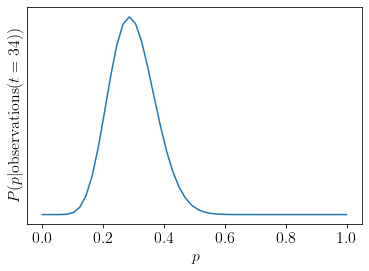

In [87]:
x = np.linspace(0, 1)
y = x**10*(1-x)**25
plt.plot(x, y)
plt.yticks([]);
plt.ylabel("$P(p|\\textrm{observations}(t=34))$")
plt.xlabel("$p$");

The maximum is now at $p=10/35\approx 0.28$ and is relatively narrow. What should we predict for the next step?

Finally, if we continue flipping more, we arrive, after 1000 more flips, at

In [11]:
for _ in range(1000):
    flips += flip()
flips

'HTHHTHTTTTTHTTHTTTTTTTTHTTTHTHHTTTTTTTHTTTTHTTTHTTTTTTTHTTTTTTTHHTTTTTTTTTHTTTTHHTTHHTTTTTTTHTTTHHTTTTTHTTTTTTTHTTHTTHHTHTHHTTTTTHTTHHTHTHHTHTTHTTTTHTTHTTHHTTTTTTHTHHTTTHTTTTTHTTTTTHTTTHTHTTTTHHTTHTTHHHTTTHTTTTTTTTHTTTTTTHTTHHTHTHTTTHTTHTTTTTTTTTTTTTHHTTHTTHTHTHTHTTTTHHTTTTTHTTTTHTTTTTTTTTHTTTHTTTTTTHHTTHHTTTHTTTTTHTTTHTHTTTTTHHTTHTHTHTHTTHTTHTTHTTTHTTTTHTTHTTTTTHTTTTTTTHTHTTTTTTTHHTTTHTTTTHHTTTTHHTHTHTHHTTHHTTTTTTTTTTTTTTTTTTTTTHTTHTTTHTTTHTTTTHHTHHHTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTHTHHHHTHTTHHTTHTTTHTHHTHHTTTHHTTTTTTTTTTTHHTHTHHTTTTHTTTTTTTTTTHTTTTTHTTTHTTHHHTTHHTHHTTTTTTTHTTHHTHTTHTTTTTTHTHTTHHTHTTHTHTTHTTTTHTTHTTTTTTTHTTHTTHTTHTTTTHHTHTTTTTHTTTHTTTTTTHTTTTTTHTHHTTTTHTHTHHTHTTHTTHHTHTTTHTHHTTTTTTTTHTTTTTTTTTTTHTTTTTTHTTTTTHTTTHTTHTTTTTTTTTTHTTHTTTTTTTTTHTTHHTTHTTTHHHTTTTTTTTHTTTTTHHTTTTTTTTTTHTHTTTTTHHTTTTHTHTTTTTTTTTTTTTHTTHTHHTTTTTTHTTTTTTTTTHTTTTTTTTHHTTTTTTTTTTTTTTHHHHHTTTTTTTHTHHTTTTTTTTHTTTTTTTHTTTTHHHTTTTHTTHHTTTHTTHTTTTHTHTTTHTTTTHTHTHTTTHTTHTHHTTTHHTTTTTTTTHTTTTTTTTHTTHTHTTHT

In [12]:
np.unique(np.array(list(flips)), return_counts=True)

(array(['H', 'T'], dtype='<U1'), array([275, 760], dtype=int64))

Text(0.5, 0, '$p$')

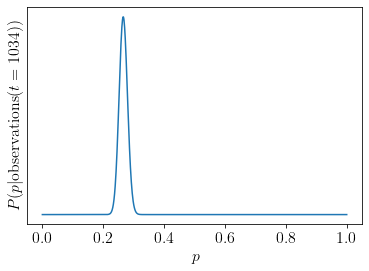

In [88]:
x = np.linspace(0, 1, 1000)
y = x**275*(1-x)**760
plt.plot(x, y)
plt.yticks([]);
plt.ylabel("$P(p|\\textrm{observations}(t=1034))$")
plt.xlabel("$p$")

We can now be pretty sure: $p\approx 0.26$. Which is quite close to the true value:

In [14]:
print(p)

0.25092362374494015


As a summary:

* at each point-in-time, we summarize all the observations into our current belief about the coin into probability $P(p|\textrm{observations})$. This distribution sums up everything we observed into a single function. This step is called filtering. Filtering is a point-in-time thing (depends on where we are in the sequence).
* the filtering helps us to make a predicton for the next step. Note that in the example above we only need most-likely $p$ to make the prediction.

We will now generalize this approach to something less trivial.

## Linear dynamic systems: simple example

Consider driving a car in one dimension. We are trying to control the car by changing its velocity (however there are other noisy disturbances influencing the car's motion). We recieve the car's position from time to time 
(these measurements are spoiled by some noise, too). Our goal is to estimate, as accurately as possible, true car's trajectory. Assuming discrete time, we may write the model, which consists of two equations:

The state equation: $x_{t}=x_{t-1} + u_{t-1} + \epsilon_{t-1}$

The observational equation: $z_{t}=x_{t} + \eta_{t}$

Here:
* $x_t$: true position of the car (unknown)
* $z_t$: measured position of the car (known)
* $u_t$: velocity of the car (known)
* $\epsilon_t$: control error (unknown) 
* $\eta_t$: measurment error (unknown) 

Finally, we assume that errors are uncorrelated and normally distributed:
$P(\epsilon_t)=\mathcal{N}(0,\sigma)$, $P(\eta_t)=\mathcal{N}(0,\rho)$

Lets generate some synthetic data.

In [254]:
rho = 5
sigma = 1
z = np_from_url('https://s264vla.storage.yandex.net/rdisk/26d0782ad0d8031f44558b8afbd393ce536cdf51cf3464c9973ad94ac3061e85/643020c5/XChvIsLTjCprW4zYIFRb_eQCtHco1lGgUFjumz14lLUJGmQFqf52NmVIb9r8xwf5ZXHdFyVQavQKktz3HiXkwA==?uid=0&filename=z_1d.npy&disposition=attachment&hash=icXORmBv8QIEM8cCAmDyesSCEZCN7CBDxZjGi2xrSacfApFTCYV5v2fAV5hxaetfq/J6bpmRyOJonT3VoXnDag%3D%3D&limit=0&content_type=application%2Foctet-stream&owner_uid=225322961&fsize=928&hid=75e6bad9aedbd1c3bb1ee4a4f069a60f&media_type=data&tknv=v2&rtoken=NQ4rEMzNx3h3&force_default=no&ycrid=na-28d4fcd05e7cfe064c5dfd674df21681-downloader4h&ts=5f8bf6005fb40&s=77efbc44774ecaf1df9911fd6c9c75f20001e6e0c0afd7a42e370a50fdd8bed3&pb=U2FsdGVkX18q2Nt7LdCzIu5-aBNiPQNvd3vyOc6LtR73IS5pMQFzInk32yh_ODWYnTHCovWV6trwnpEG-N9vVciYpRKvlgP6yi3W5dnlqVI')
u = np_from_url('https://s281vlx.storage.yandex.net/rdisk/a3ed7d59838a536ab1987eb1f8dc4b46b9188de3384423378fdc25d1f2131c50/643020d7/XChvIsLTjCprW4zYIFRb_YsEbkPiDR20rAs1eoNZkoByVpYUp1Lte0NdFCE1n8iYGiRpAxvfv9BiQCPXobfy5g==?uid=0&filename=u_1d.npy&disposition=attachment&hash=HKUmszAFnJ78t8lkQWzDkIWGFL0wyfBZDcTlRi8Y0Z30seIoG2J8/KRMpcTNmLDVq/J6bpmRyOJonT3VoXnDag%3D%3D&limit=0&content_type=application%2Foctet-stream&owner_uid=225322961&fsize=928&hid=93419bd07131320f9af7cd9a60c13857&media_type=data&tknv=v2&rtoken=kX8Cvfjd0K0M&force_default=no&ycrid=na-1c703712a2ac8a0eab7099a55f908ab0-downloader4h&ts=5f8bf6118a3c0&s=36a4d550216f73ae81b45d96b817729c47f8a1e6e09bee2d70a6b4a10c8b8601&pb=U2FsdGVkX19eUE0EJneX1KXAqPQez-z6f_2G7z9CTT14_LRLiaACBZfH5J6TwPAvelrVqbdB9Q5diU_gVzoL4IQsqMtVX14ve813y_OsWZg')

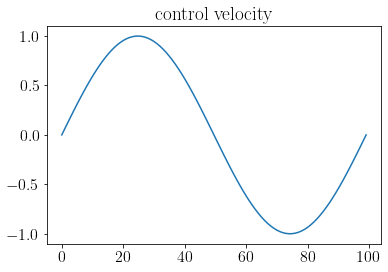

In [255]:
plt.plot(u)
plt.title('control velocity');

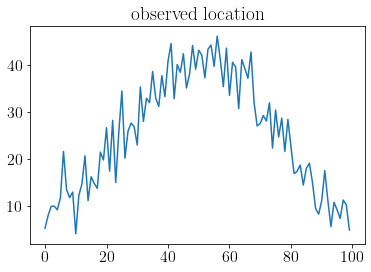

In [256]:
plt.plot(z)
plt.title('observed location');

Our goal is to extract the TRUE location. Even though we know the velocity $u$, its not trivial, as:
* we don't know the original position
* the true car's position is not fully under our control

In [257]:
z[:1]

array([5.33194534])

Something trivial we can do, though: assume $x_0=5$ (naive guess) and ignore control errors.

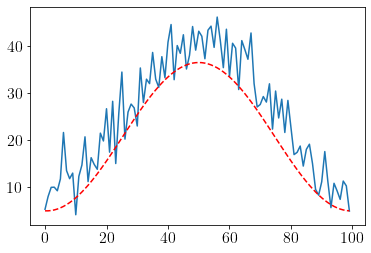

In [258]:
x = np.hstack([[5], 5+np.cumsum(u[:-1])])
plt.plot(z)
plt.plot(x, color='red', linestyle='--')

Doesn't look very good. We can do better and we begin with the filtering exercise.

In [259]:
# Concerning velocity, we know it once and for all t
u[:3]

array([0.        , 0.06342392, 0.12659245])

In [260]:
# Observations of z are coming online
z[:1]

array([5.33194534])

The first observation is that the car is at $x_0\approx 5.33$. Whats our best guess about the actual car location $x_0$ and what the std error of this guess? Recall the observation equation: $z_0=x_0 + \eta_{0}$.

$$
P(x_0|\eta_0)\propto P(\eta_0|x_0)=\frac{1}{\sqrt{2\pi}\rho}\exp\left(-\frac{\eta_0^2}{2\rho^2}\right)=\frac{1}{\sqrt{2\pi}\rho}\exp\left(-\frac{(z_0-x_0)^2}{2\rho^2}\right)
$$

Thus, after the 1st observation, our expectation can be summarized as follows

In [261]:
def normal(x, mu, s):
    return 1/(np.sqrt(2*np.pi)*s)*np.exp(-(x-mu)**2/(2*s**2))

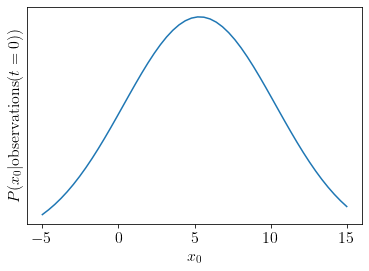

In [262]:
x = np.linspace(-5, 15)
y = normal(x, z[0], rho)
plt.plot(x, y)
plt.yticks([]);
plt.ylabel("$P(x_0|\\textrm{observations}(t=0))$")
plt.xlabel("$x_0$");

This is a distribution of the *hidden* system state $x_0$, filtered on observations up to the first one. 
* What is our best estimate for $x_0$?
* What should be our prediction for $x_1$? Recall the state equation: $x_1=x_0 + u_{0} + \epsilon_{0}$.

In [263]:
z[0] + u[0]

5.331945337820809

In [264]:
# Observations of z are coming online
z[:2]

array([5.33194534, 8.04089011])

Lets see what we do after the second observation arrives. What is our best guess for $x_1$ now?

Lets explore the formal approach first. Joint probability of $x_0$ and $x_1$ is proportional to
$$
P(x_0,x_1|\textrm{observations})\propto P(\eta_0,\eta_1,\epsilon_0|x_0,x_1)=\frac{1}{\sqrt{2\pi}\rho}\exp\left(-\frac{\eta_0^2}{2\rho^2}\right)\cdot\frac{1}{\sqrt{2\pi}\rho}\exp\left(-\frac{\eta_1^2}{2\rho^2}\right)\cdot\frac{1}{\sqrt{2\pi}\sigma}\exp\left(-\frac{\epsilon_0^2}{2\sigma^2}\right)
$$

Using the state and observational equations, we find
$$
P(x_0,x_1|\textrm{observations})\propto \frac{1}{\sqrt{2\pi}\rho}\exp\left(-\frac{(x_0-z_0)^2}{2\rho^2}\right)\cdot\frac{1}{\sqrt{2\pi}\rho}\exp\left(-\frac{(x_1-z_1)^2}{2\rho^2}\right)\cdot\frac{1}{\sqrt{2\pi}\sigma}\exp\left(-\frac{(x_1-x_0-u_0)^2}{2\sigma^2}\right)
$$

The value of $x_0$ is not know and has to be integrated out:

$$
P(x_1|\textrm{observations})\propto\int P(x_0,x_1|\textrm{observations})dx_0=\frac{\exp \left(-\frac{1}{2} \left(\frac{(u_0+z_0-x_1)^2}{\rho ^2+\sigma ^2}+\frac{(x_1-z_1)^2}{\rho ^2}\right)\right)}{2 \pi  \rho  \sqrt{\rho ^2+\sigma ^2}}
$$

Importantly, it is a normal distribution with mean 
$$
\frac{\rho ^2 (u_0+z_0+z_1)+\sigma ^2 z_1}{2 \rho ^2+\sigma ^2}
$$
and standard deviation
$$
\frac{1}{\sqrt{\frac{1}{\rho^2}+\frac{1}{\rho^2+\sigma^2}}}
$$

Let us look closer at our best estimate for $x_1$:
$$
\frac{\rho ^2 (u_0+z_0+z_1)+\sigma ^2 z_1}{2 \rho ^2+\sigma ^2} = \frac{\rho ^2+\sigma ^2}{2 \rho ^2+\sigma ^2}z_1 + \frac{\rho^2}{2 \rho ^2+\sigma ^2}(z_0+u_0)
$$

The interpretation is simple: our best estimate is a weighted combination of a current observation and the best prediction, coming from the previous step. The weights depend on the control error and measurement error.

The filtered distribution after the second step becomes:
$$
P(x_1)=\mathcal{N}(x_1|\frac{\rho ^2+\sigma ^2}{2 \rho ^2+\sigma ^2}z_1 + \frac{\rho^2}{2 \rho ^2+\sigma ^2}(z_0+u_0), \frac{1}{\sqrt{\frac{1}{\rho^2}+\frac{1}{\rho^2+\sigma^2}}})
$$.

Assuming for the moment we have only two observations in the whole series. After both observations $z_0$ and $z_1$ are done, we may compute the bet estimate for the full hidden state ($x_t$) trajectory. Clearly, for $x_1$ we have already done our best, the filtered distribution includes all the information available. However, the distribution of $x_0$ can be further improved after $z_1$ is observed!

$$
P(x_0|\textrm{observations})\propto\int P(x_0,x_1|\textrm{observations})dx_1=\frac{\exp \left(-\frac{(u_0+x_0-z_1)^2}{2 \left(\rho ^2+\sigma ^2\right)}-\frac{(x_0-z_0)^2}{2 \rho ^2}\right)}{2 \pi  \rho  \sqrt{\rho ^2+\sigma ^2}}
$$

This implies, that after the second observation arrived we have a better estimation on the position of the car at the time of the first observation, which becomes

$$
P(x_0)=\mathcal{N}(x_1|\frac{\rho ^2 (z_0+z_1-u_0)+\sigma ^2 z_0}{2 \rho ^2+\sigma ^2},\frac{1}{\sqrt{\frac{1}{\rho^2}+\frac{1}{\rho^2+\sigma^2}}})
$$.

The interpretation is, again, simple. Lets not visualize those distributions, step by step as the observations arrive.

In [265]:
w1 = rho**2+sigma**2
w2 = rho**2
w1, w2 = w1/(w1+w2), w2/(w1+w2)

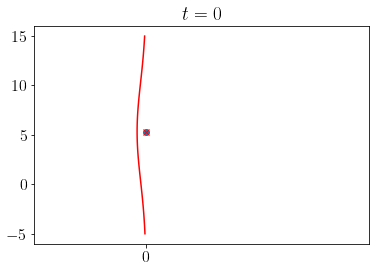

In [266]:
plt.scatter([0], z[:1])
plt.xticks([0])
plt.xlim(-1, 2)
x = np.linspace(-5, 15)
plt.plot(-normal(x, z[0], rho), x, color = 'red');
plt.plot(0, z[0], color='red', marker='x')
plt.title("$t=0$");

In [267]:
z[0]

5.331945337820809

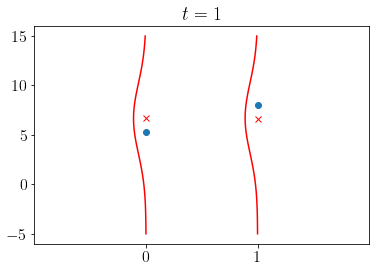

In [268]:
s = 1/np.sqrt(1/rho**2+1/(rho**2+sigma**2))
plt.scatter([0, 1], z[:2])
plt.xticks([0, 1])
plt.xlim(-1, 2)
plt.plot(-normal(x, w1*z[1]+w2*(z[0]+u[0]), s)+1, x, color = 'red')
plt.plot(0,  w1*z[1]+w2*(z[0]+u[0]), color='red', marker='x')
plt.plot(-normal(x, w1*z[0]+w2*(z[1]-u[0]), s), x, color = 'red')
plt.plot(1, w1*z[0]+w2*(z[1]-u[0]), color='red', marker='x')
plt.title("$t=1$");

In [269]:
w1*z[1]+w2*(z[0]+u[0])

6.712976004255319

Observations:
* With new information incoming, the distributions become tighter
* Two useful computations: filtering [computing the distribution of the current state given all information] and smoothening [computing the distribution of the states, observed in the past, using all available information, including the future one]

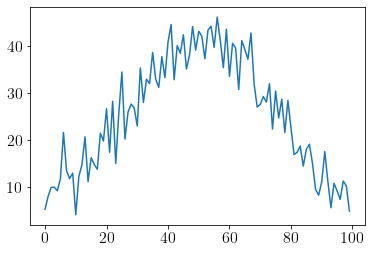

In [270]:
plt.plot(z)

We just explored two first datapoints. We can proceed with this approach further. In general, the basic equation is

$$
P(x_0,x_1,...,x_T)|\textrm{observations}(t=T))\propto P(\eta_0,...,\eta_T,\epsilon_0,...,\epsilon_{T-1}|x_0,x_1,...,x_T)=\frac{1}{\sqrt{2\pi}\rho}\exp\left(-\frac{\eta_0^2}{2\rho^2}\right)\cdot...\cdot\frac{1}{\sqrt{2\pi}\rho}\exp\left(-\frac{\eta_T^2}{2\rho^2}\right)\cdot\frac{1}{\sqrt{2\pi}\sigma}\exp\left(-\frac{\epsilon_0^2}{2\sigma^2}\right)\cdot...\cdot\frac{1}{\sqrt{2\pi}\sigma}\exp\left(-\frac{\epsilon_{T-1}^2}{2\sigma^2}\right)
$$

Through the state and observational equations: $\epsilon_{t-1}=x_{t}-x_{t-1}-u_{t-1}$, $\eta_{t}=x_{t}-z_{t}$ th RHS becomes a function of $x_0, ..., x_T$ and known parameters. The joint distribution is Gaussian; all marginal distributions will be Gaussian, too -- main property of the Linear Dynamic Systems (linear state and observational equations and Normal errors).

All integrals can be computed in a closed form, but it may be a little bit complicated if done explicitely, especially in the large-time-limit. We can do this quite efficiently, the recursive approach to evaluation of this integrals is known as a Kalman filter. We will now derive it for our simple example. We will consider only the filtering problem for now.

Since everything is Gaussian, we introduce the mean of the filtered distribution at the step $t$ and its variance:
$$
\hat x_t \quad\textrm{and}\quad\textrm{err}_t^2,
$$
which should be functions of past observations. Its convenient to write the following recursion, which generalizes our observations above
$$
\hat x_t = K_t z_t + (1-K_t) (\hat x_{t-1}+u_{t-1})
$$

At $t=0$, we have $K_0=1$, $\hat x_0 = z_0$ and $\textrm{err}_0^2=\rho^2$. Our goal is to minimize the MS of the prediction error:
\begin{align}
\hat x_t-x_t =& K_t z_t + (1-K_t)(\hat x_{t-1}+u_{t-1}) - x_t\\
             =& K_t (x_t+\eta_t) + (1-K_t)(\hat x_{t-1}+u_{t-1}) - x_t\\
             =& (1-K_t)(\hat x_{t-1}-x_{t-1}) + K\eta_t - (1-K_t)\epsilon_{t-1}
\end{align}

The thre terms in the last line are uncorrelated, hence:
$$
\mathrm{err}_t^2 = (1-K_t)^2(\mathrm{err}_{t-1}^2+\sigma^2)+K_t^2\rho^2
$$

Minimizing over $K_t$, we find:
$$
K_t = \frac{\textrm{err}_{t-1}^2+\sigma^2}{\textrm{err}_{t-1}^2+\sigma^2+\rho^2}
$$
and
$$
\textrm{err}_t^2=\rho^2\frac{\textrm{err}_{t-1}^2+\sigma^2}{\textrm{err}_{t-1}^2+\rho^2+\sigma^2}
$$

For example, we find
$$
K_1 = \frac{\rho^2+\sigma^2}{2\rho^2+\sigma^2},\quad \textrm{err}_1^2 = \rho^2\frac{\rho^2+\sigma^2}{2\rho^2+\sigma^2}
$$
fully consistent with our Gaussian integrations above!

We are now equipped to do the filtering for our full time series.

In [271]:
T = len(z)
err2 = np.zeros(T)
x_est = np.zeros(T)
K = np.zeros(T)
err2[0] = rho**2
K[0] = 1
x_est[0] = z[0]

In [278]:
for i in range(1, T):
    K[i] = (err2[i-1] + sigma**2)/(err2[i-1] + sigma**2 + rho**2)
    err2[i] = rho**2 * K[i]
    x_est[i] = K[i] * z[i] + (1-K[i])*(x_est[i-1]+u[i-1])

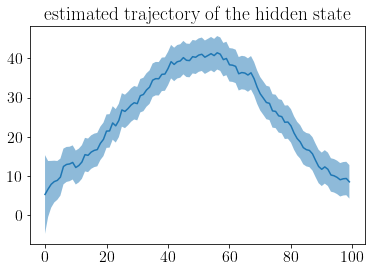

In [289]:
plt.plot(np.arange(T), x_est)
plt.fill_between(np.arange(T), x_est+2*err2**0.5, x_est-2*err2**0.5, alpha=.5)
plt.title('estimated trajectory of the hidden state');

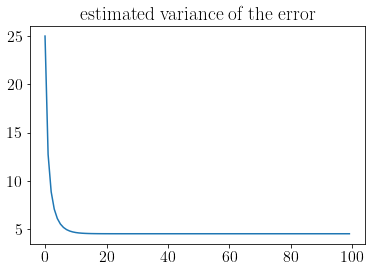

In [290]:
plt.plot(err2)
plt.title('estimated variance of the error');

In [291]:
x_true = np_from_url('https://s316vlx.storage.yandex.net/rdisk/f3c5001eaa9c8fb38f56440bffc7c6d9c445cc2433d9052c4e03f59f43d8b39c/643044a6/XChvIsLTjCprW4zYIFRb_SrdskjHEvl_zu8PFb6ez0S_xss_b0LBrXsPYT4VD5aGI5BEq6_GL9_zRM1T50IyHA==?uid=0&filename=x_1d.npy&disposition=attachment&hash=18cpSWlpbV5cGcASolIBi117ee9ZmMhIgZ/X1aOB7wnzAkzmK22ALux2hhdg06Mvq/J6bpmRyOJonT3VoXnDag%3D%3D&limit=0&content_type=application%2Foctet-stream&owner_uid=225322961&fsize=928&hid=d49120dab5c0e916e9c54b3ee088c95d&media_type=data&tknv=v2&rtoken=zagYXtbPplBK&force_default=no&ycrid=na-4355242c0878b4c1c01e243f8fbf8d5f-downloader14h&ts=5f8c1837df580&s=cc600e07303514fb739e020648d2589b2030969dd871b878e61fa02e72f2c585&pb=U2FsdGVkX1_Dq2B17hIaHA34fI8T-UTNMZsuprnWjLJ75ViaYDiwr4s3iTnU_Ucjoq8TfAc0X90yeWDYcuY8LODVbG4pHGA0t4jKOLzzAYo')

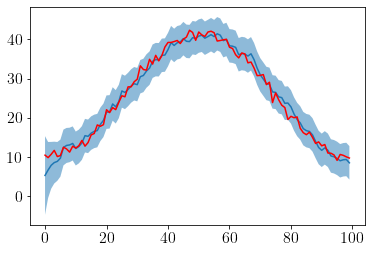

In [292]:
plt.plot(np.arange(T), x_est)
plt.fill_between(np.arange(T), x_est+2*err2**0.5, x_est-2*err2**0.5, alpha=.5)
plt.plot(np.arange(T), x_true, color='red')

In [293]:
np.mean((x_est - x_true)**2)

2.044864835776691

### Lets compare this estimation method with more naive ones in terms of MSE

14.28718940418652


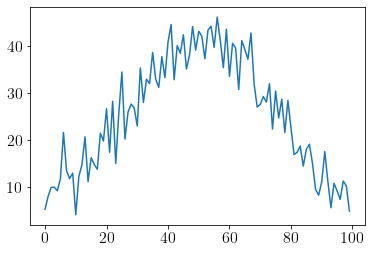

In [314]:
# what about taking raw sensor readings?
plt.plot(z)
print(np.mean((z - x_true)**2))

8.330850518300103

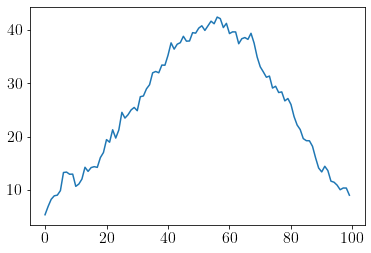

In [316]:
# or doing some EWM?
import pandas as pd
# I am overfitting here a little bit, by choosing EWM period
x_est_ewm = pd.Series(z).ewm(3).mean().values
plt.plot(x_est_ewm)
np.mean((x_est_ewm - x_true)**2)

# Summary

* LDS == Linear Dynamic Systems are governed by linear state and observation equations; Errors are Gaussian
* Can be fully solved (filtering, smoothing, prediction) via Gaussian integration
* Efficient way to do Gaussian integration: recursive equations for mean and variance of the filtered distribution aka Kalman filter

Whats next?
* Smoothing (we have not really done it for our full time series yet)
* Generalization for multi-dimensional case
* Learning the filter online: what if the control and measurement variances are unknown?